In [26]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import shap

# load the data
# please replace this path to your own real path
dfall = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ETYG_01/AETattribution_practice.csv')
df_train = dfall

X = df_train.iloc[:, 2:]  # Predictor: X
y = df_train.iloc[:, 1]   # be predicted: Y

# split the data into trainning and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=523)

In [27]:
# 1. use a simple regressor as a reference
dt_regressor = DecisionTreeRegressor(random_state=523)
dt_regressor.fit(X_train, y_train)

# the predicted results
y_pred_dt = dt_regressor.predict(X_test)

# calculate and print the R^2 score
print(f"R^2 Score for Decision Tree Regressor: {r2_score(y_test, y_pred_dt)}")

R^2 Score for Decision Tree Regressor: 0.21243409465662488


In [28]:
# set the XGBoost model
model = xgb.XGBRegressor(tree_method = "hist")

In [29]:
# step1 Random search - hyperparameter tuning
random_search_params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(model, param_distributions=random_search_params, n_iter=25, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, random_state=42)
random_search.fit(X_train, y_train) # may take a few minutes

# print the best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


In [30]:
#step3-k-fold verification
best_model = random_search.best_estimator_
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='r2')

# print the k-fold verification results
print("Cross-validated R^2 scores: ", cv_results)
print("Mean R^2 score: ", cv_results.mean())

Cross-validated R^2 scores:  [0.59531474 0.5418473  0.62450018 0.59269498 0.53799975]
Mean R^2 score:  0.5784713909335576


In [31]:
# predict the testing set
y_pred = best_model.predict(X_test)

# R^2
R2 = r2_score(y_test, y_pred)
print(f'Test MSE: {R2}')

Test MSE: 0.6247491136879173


In [32]:
import shap

# calculate the shap values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

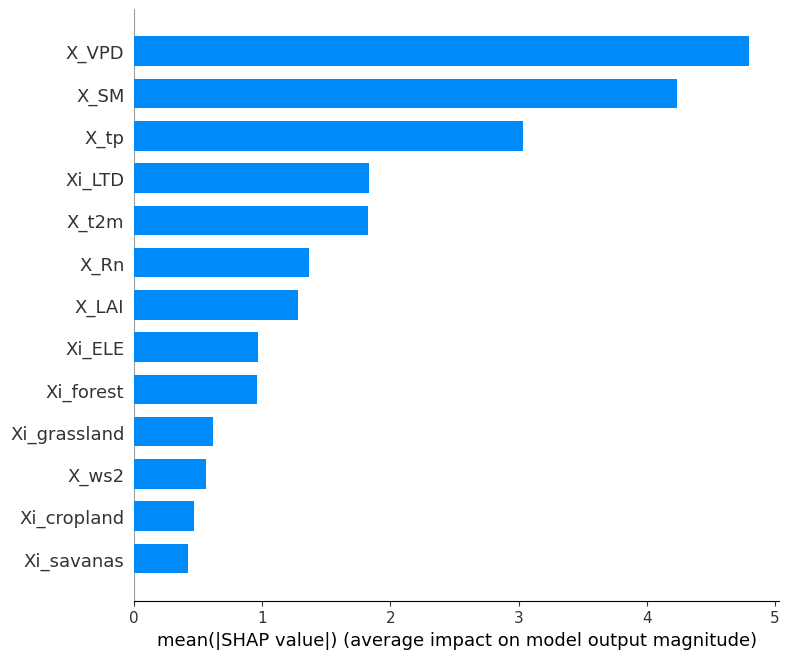

In [33]:
# 1. bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


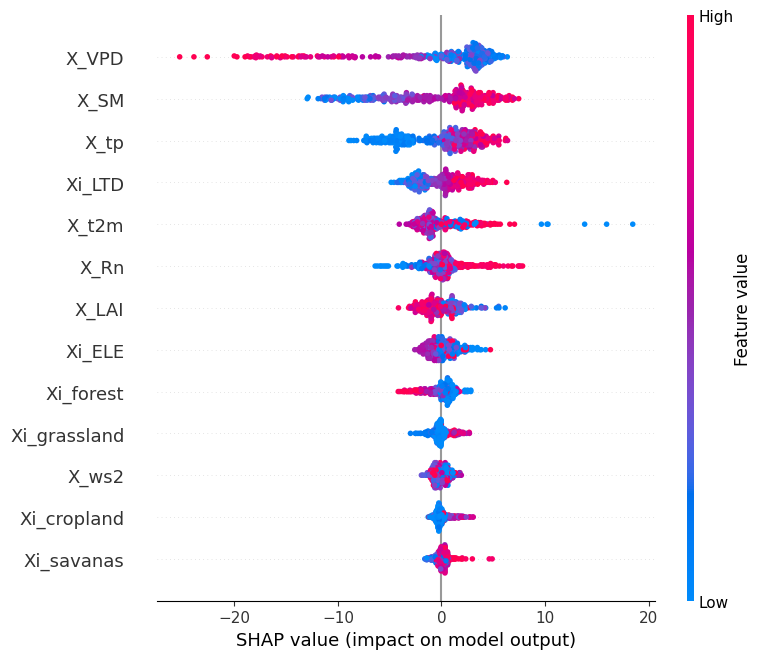

In [34]:
# 2. Bee colony diagram
shap.summary_plot(shap_values, X_test)


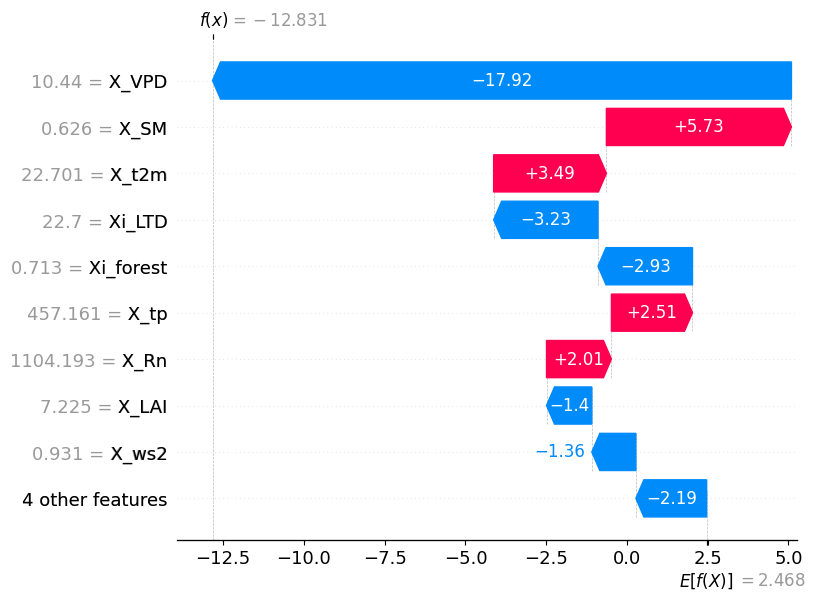

In [35]:
# 3. Waterfall chart, showing the first sample
shap.plots.waterfall(shap_values[0])
